In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from functools import reduce

In [62]:
#Params
batch_size=256
nbr_epochs=5
data_split_ratio=0.8
y_column = "600s"
file_price_x = "data/x_Swedbank_A_1_p.csv"
#files_other_x = ["data/x_Swedbank_A_0_p_macd.csv","data/x_Swedbank_A_0_p_rsi.csv"]
file_y = "data/y_Swedbank_A_500.csv"

In [63]:
x_data = pd.read_csv(file_price_x , sep=";", dtype="float32", converters = {'ts': int})
#for f in files_other_x:
#    x_data = x_data.merge(pd.read_csv(f , sep=";", dtype="float32", converters = {'ts': int}), on="ts", how='inner')
y_data = pd.read_csv(file_y , sep=";", dtype="float32", converters = {'ts': int})
y_data = y_data[y_column]
del x_data["ts"]
input_size=x_data.shape[1]

<ipython-input-63-83b4f8b4bc5d>:1: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  x_data = pd.read_csv(file_price_x , sep=";", dtype="float32", converters = {'ts': int})
<ipython-input-63-83b4f8b4bc5d>:4: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  y_data = pd.read_csv(file_y , sep=";", dtype="float32", converters = {'ts': int})


In [59]:
x_data.head()

,Swedbank_A-price-0
0,145.139999
1,145.199997
2,145.199997
3,145.199997
4,145.199997


In [61]:
y_data.head()

0    145.259995
1    145.259995
2    145.259995
3    145.259995
4    145.259995
Name: 600s, dtype: float32

In [13]:
x_data.shape

(1809210, 1)

In [14]:
y_data.shape

(1809210,)

In [8]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    d = round(len(xs[t:])/2)
    
    dev_data_x = torch.tensor(xs[t:][:d].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:][:d].values, dtype=torch.float32)
    
    test_data_x = torch.tensor(xs[t:][d:].values, dtype=torch.float32)
    test_data_y = torch.tensor(ys[t:][d:].values, dtype=torch.float32)
    
    #print(test_data_y.shape)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y), list(zip(test_data_x, test_data_y))

In [9]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#device = torch.device("cpu")
#compute_unit = "cpu"

In [10]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [11]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100).type(dtype)
        self.fc2 = nn.Linear(100, 40).type(dtype)
        self.fc3 = nn.Linear(40, 1).type(dtype)
        
        self.drop_layer = nn.Dropout(p=0.010)
    
    def forward(self, x):
        #print(x)
        fc1 = self.fc1(x)
        x = F.relu(fc1)
        x = self.drop_layer(x)
        #print(fc1)
        #print(x)
        x = F.relu(self.fc2(x))
        #print(x)
        y = F.relu(self.fc3(x))
        return y

model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [12]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for x, y in data:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)  
    
    return avg_loss, predictions

In [13]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        model.train()
        for x, y in train_data_loader:
            y = y.type(dtype)
            x = x.type(dtype)
            
            pred = model(x)

            loss = loss_fn(pred, y)
            
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [14]:
#Start training
train_data, dev_data, test_data = splitData(x_data, y_data, data_split_ratio)
train_data_loader = DataLoader(train_data, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size)
model = model.to(device)
train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)



/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([199])) that is different to the input size (torch.Size([199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([185])) that is different to the input size (torch.Size([185, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s

Epoch 0 	Loss: 287.595 	Loss (val): 0.520


KeyboardInterrupt: 

In [ ]:
_, preds = evaluate_model(test_data, model, loss_fn)

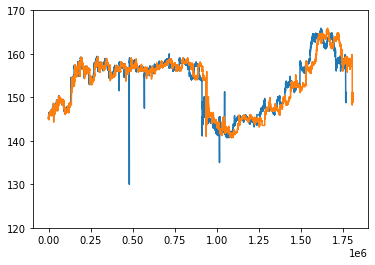

In [64]:
y_data_borpi = list(y_data)
x_data_borpi = list(x_data["Swedbank_A-price-0"])
plt.plot(list(range(len(y_data_borpi))), y_data_borpi)
plt.plot(list(range(len(x_data_borpi))), x_data_borpi)
axes = plt.gca()
axes.set_ylim([120,170])
#axes.set_xlim([250000,265000])
#axes.set_xlim([100000,120000])
#axes.set_xlim([141600,140630])
plt.show()
#axes = plt.gca()
#axes.set_ylim([120,170])
#plt.show()